In [1]:
import warnings
from itertools import product
import glob
from datetime import datetime
from datetime import timedelta
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.feature as cf
import shapely.geometry as sgeom

from sklearn.decomposition import PCA
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

import pickle
import copy
from shapely import geometry
from sklearn.metrics.pairwise import euclidean_distances

In [2]:
13*5

65

In [3]:
import string
abcd = list(string.ascii_lowercase)

In [4]:
df_test = pd.read_csv('../ProcessZ500/labels/df_labels_nocorrfilt_ERA5.csv',
                      index_col=0,parse_dates=True)
df_test = df_test['1948-01-01':'2023-12-31']

df_test.loc[df_test['corr']<=0.2,'WR']=np.unique(df_test['WR'])[-1]

# Read data

## b) frequency past and present

In [5]:
dic_labels = {}
names_reanalyses = ['ERA5','JRA3Q','NCEP_NCAR']
for reanalysis in names_reanalyses:
    labels_temp = pd.read_csv(f'../ProcessZ500/labels/df_labels_nocorrfilt_{reanalysis}.csv', parse_dates=True, index_col=0, 
                              names=['WR','distances','corr'], skiprows=1)#[['WR']]
    labels_temp = labels_temp['1948':]
    labels_temp['season'] = labels_temp.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    labels_temp['season'] = labels_temp['season'].map(season_map)
    labels_temp.loc[labels_temp['corr']<=0.2,'WR']=np.unique(labels_temp['WR'])[-1]
    dic_labels[reanalysis] = labels_temp

In [6]:
freqs_dic = {}
for reanalysis in names_reanalyses:
    df_temp = dic_labels[reanalysis]
    df_season = df_temp[(df_temp['season']=='Winter')|(df_temp['season']=='Spring')]
    freqs_past = 100*df_season['1948':'1977'].groupby('WR').count()['distances']/len(df_season['1948':'1977'])
    freqs_present = 100*df_season['1994':'2023'].groupby('WR').count()['distances']/len(df_season['1994':'2023'])
    freqs_dic[f'{reanalysis}_present'] = freqs_present
    freqs_dic[f'{reanalysis}_past'] = freqs_past

In [7]:
for reanalysis in names_reanalyses:
    df_temp = dic_labels[reanalysis]
    df_season = df_temp[(df_temp['season']=='Winter')|(df_temp['season']=='Spring')]
    df_season['year'] = df_season.index.year
    
    q05_past = []
    q95_past = []
    q05_present = []
    q95_present = []
    for wr in range(6):
        df_temp = df_season[df_season['WR']==wr]
        yearly_freq_past = 100*df_temp['1948':'1977'].groupby('year').count()['WR']/(365/2)
        bootstrapped_yearly_freqs = []
        for i in range(1000):
            np.random.seed(i)
            bootstrapped_yearly_freqs.append(np.random.choice(yearly_freq_past.values,size=len(yearly_freq_past)))
        
        q05_past.append(np.quantile(np.mean(np.array(bootstrapped_yearly_freqs),axis=1),0.05,axis=0))
        q95_past.append(np.quantile(np.mean(np.array(bootstrapped_yearly_freqs),axis=1),0.95,axis=0))
    
        df_temp = df_season[df_season['WR']==wr]
        yearly_freq_past = 100*df_temp['1994':'2023'].groupby('year').count()['WR']/(365/2)
        bootstrapped_yearly_freqs = []
        for i in range(1000):
            np.random.seed(i)
            bootstrapped_yearly_freqs.append(np.random.choice(yearly_freq_past.values,size=len(yearly_freq_past)))
        
        q05_present.append(np.quantile(np.mean(np.array(bootstrapped_yearly_freqs),axis=1),0.05,axis=0))
        q95_present.append(np.quantile(np.mean(np.array(bootstrapped_yearly_freqs),axis=1),0.95,axis=0))
    
    freqs_dic[f'{reanalysis}_past_q05'] = np.array(q05_past)
    freqs_dic[f'{reanalysis}_past_q95'] = np.array(q95_past)
    freqs_dic[f'{reanalysis}_present_q05'] = np.array(q05_present)
    freqs_dic[f'{reanalysis}_present_q95'] = np.array(q95_present)

/glade/derecho/scratch/jhayron/tmp/ipykernel_53473/2384812260.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_season['year'] = df_season.index.year
/glade/derecho/scratch/jhayron/tmp/ipykernel_53473/2384812260.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_season['year'] = df_season.index.year
/glade/derecho/scratch/jhayron/tmp/ipykernel_53473/2384812260.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

## c)d) Tmax anoms and corr

In [8]:
tmax_anoms = xr.open_dataset('../ProcessERA5_Surface/composites_data/tmax_anoms.nc')

In [9]:
arr = tmax_anoms.composite.values
arr[(arr<=tmax_anoms.q95.values)&(arr>=tmax_anoms.q05.values)] = np.nan
tmax_anoms.composite.data = arr

In [10]:
tmax_corr = xr.open_dataset('../ProcessERA5_Surface/corr_data/corr_tmax_anoms.nc')

## g)h) Tmin anoms and corr

In [11]:
tmin_anoms = xr.open_dataset('../ProcessERA5_Surface/composites_data/tmin_anoms.nc')

In [12]:
arr = tmin_anoms.composite.values
arr[(arr<=tmin_anoms.q95.values)&(arr>=tmin_anoms.q05.values)] = np.nan
tmin_anoms.composite.data = arr

In [13]:
tmin_corr = xr.open_dataset('../ProcessERA5_Surface/corr_data/corr_tmin_anoms.nc')

## e)f) Precip anoms and corr

In [14]:
precip_anoms = xr.open_dataset('../ProcessERA5_Surface/composites_data/precip_anoms.nc')

In [15]:
arr = precip_anoms.composite.values
arr[(arr<=precip_anoms.q95.values)&(arr>=precip_anoms.q05.values)] = np.nan
precip_anoms.composite.data = arr

In [16]:
precip_corr = xr.open_dataset('../ProcessERA5_Surface/corr_data/corr_precip_anoms.nc')

## i)j) dry spell duration anoms and corr

In [17]:
durdry_composite = xr.open_dataset('../ProcessERA5_Surface/composites_data/durdryspells_mean.nc')

In [18]:
durdry_composite_full = xr.open_dataset('../ProcessERA5_Surface/composites_data/durdryspells_mean_full.nc')

In [19]:
arr = durdry_composite.composite.values
arr[(arr<=durdry_composite.q95.values)&(arr>=durdry_composite.q05.values)] = np.nan
arr = (arr-durdry_composite_full['mean'].values)#/durdry_composite_full['std'].values
durdry_composite.composite.data = arr

In [20]:
durdry_corr = xr.open_dataset('../ProcessERA5_Surface/corr_data/corr_durdryspells.nc')

## i)j) warm spells anoms and corr

In [21]:
ws_composite = xr.open_dataset('../ProcessERA5_Surface/composites_data/warm_spells_count.nc')

In [22]:
arr = ws_composite.composite.values
arr[(arr<=ws_composite.q90.values)] = np.nan
ws_composite.composite.data = arr

In [23]:
ws_corr = xr.open_dataset('../ProcessERA5_Surface/corr_data/corr_ws.nc')

In [24]:
ws_composite_full_season = xr.open_dataset('../ProcessERA5_Surface/composites_data/warm_spells_count_season.nc')

In [25]:
ws_ratio = 100*ws_composite.composite/ws_composite_full_season.composite

## i)j) ext. hot days anoms and corr

In [26]:
tx90_composite = xr.open_dataset('../ProcessERA5_Surface/composites_data/tx90_count.nc')

In [27]:
arr = tx90_composite.composite.values
arr[(arr<=tx90_composite.q90.values)] = np.nan
tx90_composite.composite.data = arr

In [28]:
tx90_corr = xr.open_dataset('../ProcessERA5_Surface/corr_data/corr_tx90_anoms.nc')

In [29]:
tx90_composite_full_season = xr.open_dataset('../ProcessERA5_Surface/composites_data/tx90_count_season.nc')

In [30]:
tx90_ratio = 100*tx90_composite.composite/tx90_composite_full_season.composite

## i)j) tropical days anoms and corr

In [31]:
tx25_composite = xr.open_dataset('../ProcessERA5_Surface/composites_data/tx25_count.nc')

In [32]:
arr = tx25_composite.composite.values
# arr[(arr<=tx25_composite.q90.values)] = np.nan
tx25_composite.composite.data = arr

In [33]:
tx25_corr = xr.open_dataset('../ProcessERA5_Surface/corr_data/corr_tx25_anoms.nc')

## i)j) fires anooms and corr

In [34]:
fires_composite = xr.open_dataset('../ProcessERA5_Surface/composites_data/fires_count.nc')

In [35]:
arr = fires_composite.composite.values
arr[(arr<=fires_composite.q90.values)] = np.nan
fires_composite.composite.data = arr

In [36]:
fires_corr = xr.open_dataset('../ProcessERA5_Surface/corr_data/corr_fires.nc')

In [37]:
fires_composite_full_season = xr.open_dataset('../ProcessERA5_Surface/composites_data/fires_count_seasonal.nc')

In [38]:
fires_ratio = 100*fires_composite.composite/fires_composite_full_season.fire_composite

# Plots

/glade/derecho/scratch/jhayron/tmp/ipykernel_13995/4171518988.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(3, 4, 1, projection=ccrs.AlbersEqualArea(
/glade/derecho/scratch/jhayron/tmp/ipykernel_13995/4171518988.py:59: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(3, 4, 2, projection=ccrs.AlbersEqualArea(
/glade/derecho/scratch/jhayron/tmp/ipykernel_13995/4171518988.py:97: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(3, 4, 3, projection=ccrs.AlbersEqualArea(
/glade/derecho/scratch/jhayron/tmp/ipykernel_13995/4171518988.py:135: MatplotlibDeprecationWar

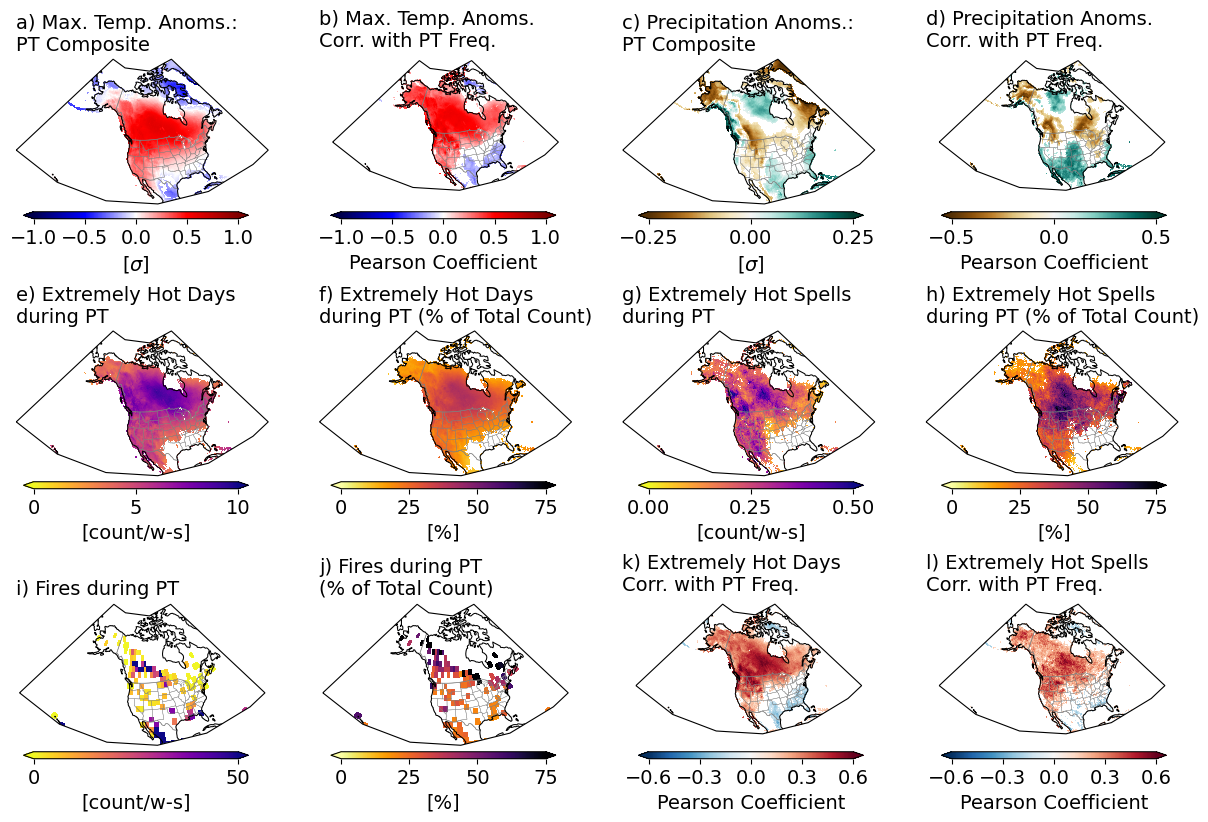

In [40]:
fontsize_most_things = 14

fig, axs = plt.subplots(
        3, 4,
        figsize=(15, 10))

axs_list = axs.flatten().tolist()
extent = [-180, -50, 20, 80]
# Create a rectangular boundary matching the extent
verts = [
    (extent[0], extent[2]),  # Bottom-left corner
    (extent[1], extent[2]),  # Bottom-right corner
    (extent[1], extent[3]),  # Top-right corner
    (extent[0], extent[3]),  # Top-left corner
    (extent[0], extent[2])   # Closing the rectangle
]


# ################# PLOT Tmax anoms ######################

ax = plt.subplot(3, 4, 1, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-1
maxi=1
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(tmax_anoms.lon, 
        tmax_anoms.lat, 
        tmax_anoms.composite,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='seismic')

ax.set_title(
    f'a) Max. Temp. Anoms.:\nPT Composite', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.13, 0.68, 0.15, 0.007])
ticks_1 = [-1,-0.5, 0, 0.5,1]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[$\sigma$]', fontsize=fontsize_most_things)

# ################# PLOT Tmax correlation ######################

ax = plt.subplot(3, 4, 2, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-1
maxi=1
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(tmax_corr.lon, 
        tmax_corr.lat, 
        tmax_corr.correlation,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='seismic')

ax.set_title(
    f'b) Max. Temp. Anoms.\nCorr. with PT Freq.', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.335, 0.68, 0.15, 0.007])
ticks_1 = [-1, -0.5, 0, 0.5, 1]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('Pearson Coefficient', fontsize=fontsize_most_things)

# ################# PLOT Precip anoms ######################

ax = plt.subplot(3, 4, 3, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-0.25
maxi=0.25
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(precip_anoms.lon, 
        precip_anoms.lat, 
        precip_anoms.composite,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='BrBG')

ax.set_title(
    f'c) Precipitation Anoms.:\nPT Composite', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.54, 0.68, 0.15, 0.007])
ticks_1 = [-0.25, 0, 0.25]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[$\sigma$]', fontsize=fontsize_most_things)

# ################# PLOT Precip correlation ######################

ax = plt.subplot(3, 4, 4, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-0.5
maxi=0.5
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(precip_corr.lon, 
        precip_corr.lat, 
        precip_corr.correlation,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='BrBG')

ax.set_title(
    f'd) Precipitation Anoms.\nCorr. with PT Freq.', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.742, 0.68, 0.15, 0.007])
ticks_1 = [-1, -0.5, 0, 0.5, 1]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('Pearson Coefficient', fontsize=fontsize_most_things)

 ################# PLOT TX90 composite ######################

ax = plt.subplot(3, 4, 5, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=0
maxi=10
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(tx90_composite.lon, 
        tx90_composite.lat, 
        tx90_composite.composite,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='plasma_r')

ax.set_title(
    f'e) Extremely Hot Days\nduring PT', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.13, 0.41, 0.15, 0.007])
ticks_1 = [0,5,10]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[count/w-s]', fontsize=fontsize_most_things)

 ################# PLOT TX90 ratio ######################

ax = plt.subplot(3, 4, 6, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=0
maxi=75
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(tx90_ratio.lon, 
        tx90_ratio.lat, 
        tx90_ratio,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='inferno_r')

ax.set_title(
    f'f) Extremely Hot Days\nduring PT (% of Total Count)', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.335, 0.41, 0.15, 0.007])
ticks_1 = [0,25,50,75]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[%]', fontsize=fontsize_most_things)

 ################# PLOT WS composite ######################

ax = plt.subplot(3, 4, 7, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=0
maxi=0.5
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(ws_composite.lon, 
        ws_composite.lat, 
        ws_composite.composite,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='plasma_r')

ax.set_title(
    f'g) Extremely Hot Spells\nduring PT', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.54, 0.41, 0.15, 0.007])
ticks_1 = [0,0.25,0.5]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[count/w-s]', fontsize=fontsize_most_things)

 ################# PLOT WS ratio ######################

ax = plt.subplot(3, 4, 8, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=0
maxi=75
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(ws_ratio.lon, 
        ws_ratio.lat, 
        ws_ratio,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='inferno_r')

ax.set_title(
    f'h) Extremely Hot Spells\nduring PT (% of Total Count)', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.742, 0.41, 0.15, 0.007])
ticks_1 = [0,25,50,75]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[%]', fontsize=fontsize_most_things)

 ################# PLOT Fires composite ######################

ax = plt.subplot(3, 4, 9, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=0
maxi=50
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(fires_composite.lon, 
        fires_composite.lat, 
        fires_composite.composite,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='plasma_r')

ax.set_title(
    f'i) Fires during PT', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())


cbar_ax = fig.add_axes([0.13, 0.14, 0.15, 0.007])
ticks_1 = [0,50]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[count/w-s]', fontsize=fontsize_most_things)

 ################# PLOT Fires ratio ######################

ax = plt.subplot(3, 4, 10, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=0
maxi=75
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(fires_ratio.lon, 
        fires_ratio.lat, 
        fires_ratio,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='inferno_r')

ax.set_title(
    f'j) Fires during PT\n(% of Total Count)', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.335, 0.14, 0.15, 0.007])
ticks_1 = [0,25,50,75]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[%]', fontsize=fontsize_most_things)


# ################# PLOT extremely hot days corr ######################

ax = plt.subplot(3, 4, 11, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-0.6
maxi=0.6
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(tx90_corr.lon, 
        tx90_corr.lat, 
        tx90_corr.correlation,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='RdBu_r')

ax.set_title(
    f'k) Extremely Hot Days\nCorr. with PT Freq.', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.54, 0.14, 0.15, 0.007])
ticks_1 = [-0.6, -0.3, 0, 0.3, 0.6]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('Pearson Coefficient', fontsize=fontsize_most_things)

# ################# PLOT warm spells PT corr ######################

ax = plt.subplot(3, 4, 12, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-0.6
maxi=0.6
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(ws_corr.lon, 
        ws_corr.lat, 
        ws_corr.correlation,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='RdBu_r')

ax.set_title(
    f'l) Extremely Hot Spells\nCorr. with PT Freq.', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())


cbar_ax = fig.add_axes([0.742, 0.14, 0.15, 0.007])
ticks_1 = [-0.6, -0.3, 0, 0.3, 0.6]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('Pearson Coefficient', fontsize=fontsize_most_things)

# plt.tight_layout()
plt.savefig('nFigures/3_PT_Composites.pdf',bbox_inches='tight')

NameError: name 'tx90_pt_diff' is not defined

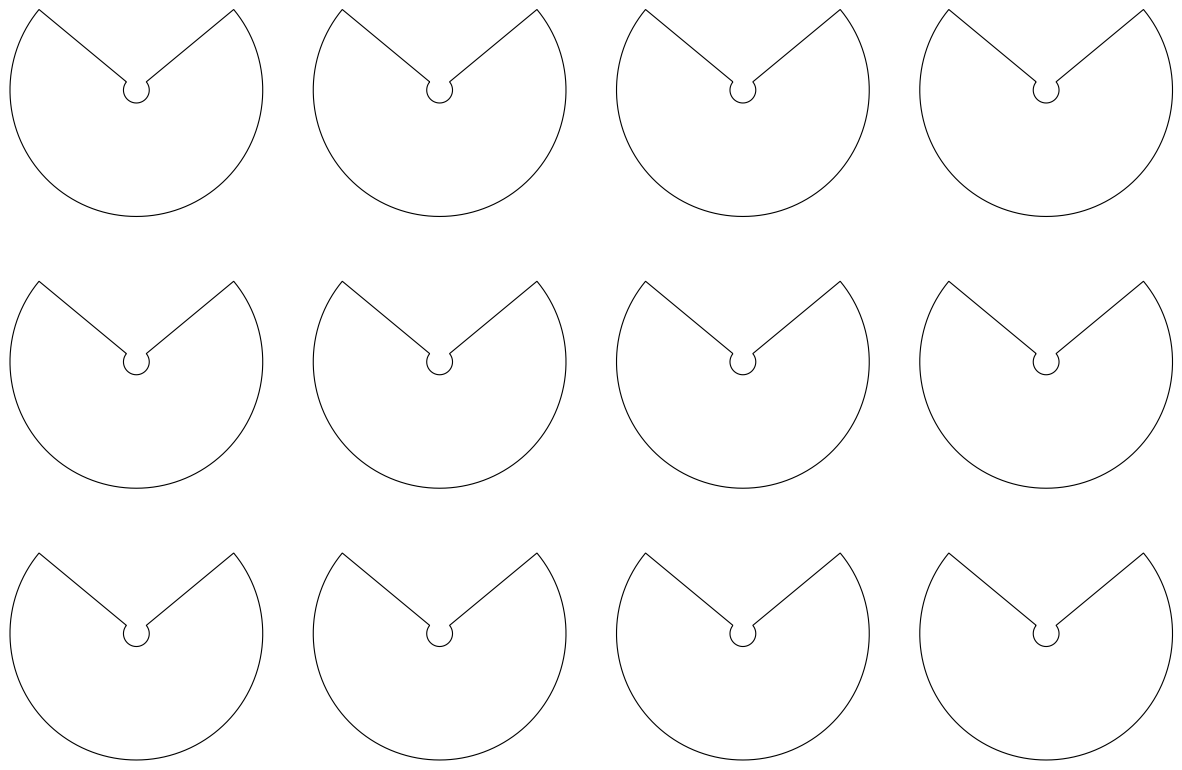

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.path as mpath

fontsize_most_things = 14

fig, axs = plt.subplots(4, 3, figsize=(15, 13))
axs_list = axs.flatten().tolist()

extent = [-180, -50, 20, 80]
verts = [
    (extent[0], extent[2]), (extent[1], extent[2]),
    (extent[1], extent[3]), (extent[0], extent[3]),
    (extent[0], extent[2])
]

# ========== Subplot positions ==========
subplot_positions = {
    1: ('tmax_anoms', 'composite', 'seismic', (-1, 1), 'a) Max. Temp. Anoms.:\nPT Composite', '[$\\sigma$]', [0.13, 0.80]),
    2: ('tmax_corr', 'correlation', 'seismic', (-1, 1), 'b) Max. Temp. Anoms.\nCorr. with PT Freq.', 'Pearson Coefficient', [0.335, 0.80]),
    3: ('precip_anoms', 'composite', 'BrBG', (-0.25, 0.25), 'c) Precipitation Anoms.:\nPT Composite', '[$\\sigma$]', [0.54, 0.80]),
    4: ('precip_corr', 'correlation', 'BrBG', (-0.5, 0.5), 'd) Precipitation Anoms.\nCorr. with PT Freq.', 'Pearson Coefficient', [0.742, 0.80]),
    5: ('tx90_composite', 'composite', 'plasma_r', (0, 10), 'e) Extremely Hot Days\nduring PT', '[count/w-s]', [0.13, 0.57]),
    6: ('tx90_ratio', None, 'inferno_r', (0, 75), 'f) Extremely Hot Days\n(% of Total Count)', '[%]', [0.335, 0.57]),
    7: ('ws_composite', 'composite', 'plasma_r', (0, 0.5), 'g) Extremely Hot Spells\nduring PT', '[count/w-s]', [0.54, 0.57]),
    8: ('ws_ratio', None, 'inferno_r', (0, 75), 'h) Extremely Hot Spells\n(% of Total Count)', '[%]', [0.742, 0.57]),
    9: ('fires_composite', 'composite', 'plasma_r', (0, 50), 'i) Fires during PT', '[count/w-s]', [0.13, 0.34]),
    10: ('fires_ratio', None, 'inferno_r', (0, 75), 'j) Fires during PT\n(% of Total Count)', '[%]', [0.335, 0.34]),
    11: ('tx90_corr', 'correlation', 'RdBu_r', (-0.6, 0.6), 'k) Extremely Hot Days\nCorr. with PT Freq.', 'Pearson Coefficient', [0.54, 0.34]),
    12: ('ws_corr', 'correlation', 'RdBu_r', (-0.6, 0.6), 'l) Extremely Hot Spells\nCorr. with PT Freq.', 'Pearson Coefficient', [0.742, 0.34]),
}

# ========== Plot loop ==========
for i in range(1, 13):
    varname, field, cmap, (vmin, vmax), title, cbar_label, cbar_pos = subplot_positions[i]
    ax = plt.subplot(4, 3, i, projection=ccrs.AlbersEqualArea(
        central_longitude=-115, central_latitude=50, standard_parallels=(30, 70)))

    data_obj = globals()[varname]
    data_field = data_obj if field is None else getattr(data_obj, field)

    pm = ax.pcolormesh(
        data_obj.lon, data_obj.lat, data_field,
        transform=ccrs.PlateCarree(),
        vmin=vmin, vmax=vmax, cmap=cmap
    )

    ax.set_title(title, fontsize=fontsize_most_things, loc='left')
    ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
    ax.margins(x=0, y=0)
    ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)
    ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)
    rect = mpath.Path(verts)
    ax.set_boundary(rect, transform=ccrs.PlateCarree())

    # Colorbar
    cbar_ax = fig.add_axes([cbar_pos[0], cbar_pos[1], 0.15, 0.007])
    if vmin == 0 and vmax == 75:
        ticks = [0, 25, 50, 75]
    elif vmin == 0 and vmax == 50:
        ticks = [0, 50]
    elif vmin == 0 and vmax == 10:
        ticks = [0, 5, 10]
    elif vmin == 0 and vmax == 0.5:
        ticks = [0, 0.25, 0.5]
    elif vmin == -0.6 and vmax == 0.6:
        ticks = [-0.6, -0.3, 0, 0.3, 0.6]
    elif vmin == -0.5 and vmax == 0.5:
        ticks = [-0.5, 0, 0.5]
    elif vmin == -0.25 and vmax == 0.25:
        ticks = [-0.25, 0, 0.25]
    else:
        ticks = [vmin, 0, vmax]

    cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks, orientation='horizontal', extend='both')
    cbar.ax.tick_params(labelsize=fontsize_most_things)
    cbar.set_label(cbar_label, fontsize=fontsize_most_things)

# Save figure
plt.savefig('nFigures/3_PT_Composites_4x3.png', bbox_inches='tight')
